# HDF5 in Python

In [251]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

In [260]:
%matplotlib inline

In [13]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import h5py
import tables as tb
import matplotlib.pyplot as plt
from hurry.filesize import size

In [299]:
# tab-completion for groups and attributes
?h5py.enable_ipython_completer
h5py.enable_ipython_completer()

# Data

In [4]:
data_dir = os.path.join(os.getcwd(), 'data')
print(data_dir)

/home/jack/Repos/hdf5-pydata-munich/data


In [86]:
arr = np.random.normal(loc=0, scale=1, size=200)
matrix = np.random.random((100, 50)).astype('float32')
print('arr: {} - {}'.format(arr.shape, arr.dtype))
print('matrix: {} - {}'.format(matrix.shape, matrix.dtype))

arr: (200,) - float64
matrix: (100, 50) - float32


# h5py

The h5py library is a thin, pythonic wrapper around the HDF5 C API.

It tries to expose most of the functionality that the HDF5 library provides.

### Write

In [115]:
file_path = os.path.join(data_dir, 'h5py-file.h5')

f = h5py.File(file_path, 'w')
f.create_dataset(name='MyDataset', shape=matrix.shape, dtype=matrix.dtype, data=matrix)
f.close()

### More pythonic approaches

In [88]:
file_path = os.path.join(data_dir, 'h5py-context-manager0.h5')

with h5py.File(file_path, 'w') as f:
    f.create_dataset('MyDataset', matrix.shape, matrix.dtype, matrix)

In [89]:
file_path = os.path.join(data_dir, 'h5py-context-manager1.h5')

with h5py.File(file_path, 'w') as f:
    # create the datasets first
    ds0 = f.create_dataset('Dataset0', matrix.shape, matrix.dtype)
    ds1 = f.create_dataset('Dataset1', matrix.shape, matrix.dtype)
    # fill them up later. There are 2 syntaxes.
    ds0[:] = matrix
    ds1[...] = matrix

### Pick the correct HDF5 datatype

In [255]:
file_path = os.path.join(data_dir, 'h5py-different-datatypes.h5')

with h5py.File(file_path, 'w') as f:
    f.create_dataset('numpy_dtype', arr.shape, arr.dtype, arr)
    f.create_dataset('IEEE_F64_Big_Endian', arr.shape, h5py.h5t.IEEE_F64BE, arr)
    # if we store floats as unsigned integers (8 bit) we end up with invalid data
    f.create_dataset('Unsigned_8Bit_Big_Endian', arr.shape, h5py.h5t.STD_U8BE, arr)
    
with h5py.File(file_path, 'r') as f:
    print('Original data')
    print(arr[:10])
    print('Saved as...')
    print(f['Unsigned_8Bit_Big_Endian'][:10])

Original data
[ 1.32269107 -2.05758328 -2.38165754  0.27669639  0.2522522  -0.43412936
 -0.2347679  -0.64872182  0.70158161  1.69028536]
Saved as...
[1 0 0 0 0 0 0 0 0 1]


### Groups, Datasets, Attributes

In [183]:
file_path = os.path.join(data_dir, 'h5py-groups-datasets-attributes.h5')

with h5py.File(file_path, 'w') as f:
    ds0 = f.create_dataset('MyDatasetInRoot', arr.shape, arr.dtype)
    ds0[:] = arr
    ds0.attrs['Unit'] = 'm/s'
    # attributes can be numpy array too!
    attr_data = np.zeros((2,), dtype='int32')
    attr_data[0] = 100
    attr_data[1] = 200
    ds0.attrs.create(name='Speed', data=attr_data)
    
    # create a group by using an absolute path.
    # Missing groups along the path will be created automatically.
    path_to_group = '/SomeMissingGroup/MyGroup'
    gr0 = f.create_group(path_to_group)
    
    # create a group by using a relative path
    gr1 = gr0.create_group('MyOtherGroup')
    
    # access a group with an absolute path
    my_group = f['/SomeMissingGroup/MyGroup']
    
    # access a group with a relative path
    root_group = my_group.parent.parent

    # set some attributes to the groups
    gr0.attrs['Experiment ID'] = 123
    gr1.attrs['Experiment ID'] = 456
    
    # create a dataset inside a group
    ds_in_group = gr1.create_dataset('MyOtherDataset', matrix.shape, matrix.dtype)
    # if you have a reference to the dataset, you can set the data with this syntax: 
    # ds_in_group[:] = matrix
    # otherwise you have to know the absolute path to your dataset
    path_to_dataset = '/SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset'
    f[path_to_dataset][:] = matrix
    
    # set some attributes to this other dataset
    ds_in_group.attrs['Unit'] = '°C'
    ds_in_group.attrs['Recorded on'] = '25th November 2017'

### Traverse a HDF5 file with h5py

The last file we created has several datasets and groups.

Let's see how we can traverse a HDF5 file and display its structure.

In [107]:
help(f.visit)

Help on method visit in module h5py._hl.group:

visit(func) method of h5py._hl.files.File instance
    Recursively visit all names in this group and subgroups (HDF5 1.8).
    
    You supply a callable (function, method or callable object); it
    will be called exactly once for each link in this group and every
    group below it. Your callable must conform to the signature:
    
        func(<member name>) => <None or return value>
    
    Returning None continues iteration, returning anything else stops
    and immediately returns that value from the visit method.  No
    particular order of iteration within groups is guranteed.
    
    Example:
    
    >>> # List the entire contents of the file
    >>> f = File("foo.hdf5")
    >>> list_of_names = []
    >>> f.visit(list_of_names.append)



In [127]:
def print_name(name):
    print(name)

file_path = os.path.join(data_dir, 'h5py-groups-datasets-attributes.h5')

with h5py.File(file_path, 'r') as f:
    # the callable to supply to visit has <member name>
    f.visit(print_name)

MyDatasetInRoot
SomeMissingGroup
SomeMissingGroup/MyGroup
SomeMissingGroup/MyGroup/MyOtherGroup
SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset


In [111]:
help(f.visititems)

Help on method visititems in module h5py._hl.group:

visititems(func) method of h5py._hl.files.File instance
    Recursively visit names and objects in this group (HDF5 1.8).
    
    You supply a callable (function, method or callable object); it
    will be called exactly once for each link in this group and every
    group below it. Your callable must conform to the signature:
    
        func(<member name>, <object>) => <None or return value>
    
    Returning None continues iteration, returning anything else stops
    and immediately returns that value from the visit method.  No
    particular order of iteration within groups is guranteed.
    
    Example:
    
    # Get a list of all datasets in the file
    >>> mylist = []
    >>> def func(name, obj):
    ...     if isinstance(obj, Dataset):
    ...         mylist.append(name)
    ...
    >>> f = File('foo.hdf5')
    >>> f.visititems(func)



In [140]:
def print_name_and_type(name, obj):
    class_name = obj.__class__.__name__
    print('{} is a {}'.format(name, class_name))
    attributes =list(obj.attrs.items())
    print('{} has these attributes: {}\n'.format(name, attributes))

file_path = os.path.join(data_dir, 'h5py-groups-datasets-attributes.h5')

with h5py.File(file_path, 'r') as f:
    # the callable to supply to visititems has <member name>, <object>
    f.visititems(print_name_and_type)

MyDatasetInRoot is a Dataset
MyDatasetInRoot has these attributes: [('Unit', 'm/s'), ('Speed', array([100, 200], dtype=int32))]

SomeMissingGroup is a Group
SomeMissingGroup has these attributes: []

SomeMissingGroup/MyGroup is a Group
SomeMissingGroup/MyGroup has these attributes: [('Experiment ID', 123)]

SomeMissingGroup/MyGroup/MyOtherGroup is a Group
SomeMissingGroup/MyGroup/MyOtherGroup has these attributes: [('Experiment ID', 456)]

SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset is a Dataset
SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset has these attributes: [('Unit', '°C'), ('Recorded on', '25th November 2017')]



### Plot

<HDF5 dataset "MyDatasetInRoot": shape (200,), type "<f8">
['Unit', 'Speed']
['m/s', array([100, 200], dtype=int32)]
[('Unit', 'm/s'), ('Speed', array([100, 200], dtype=int32))]


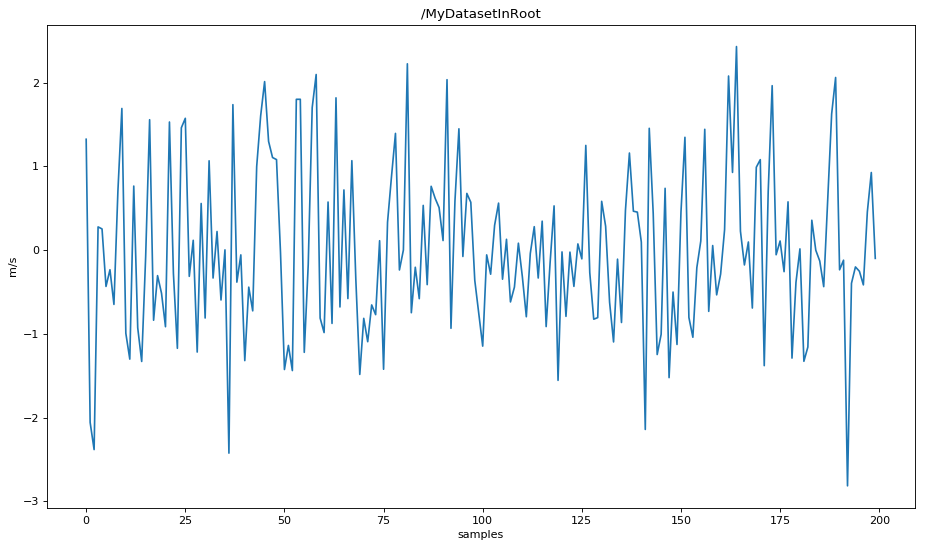

In [171]:
file_path = os.path.join(data_dir, 'h5py-groups-datasets-attributes.h5')

with h5py.File(file_path, 'r') as f:
    ds = f['MyDatasetInRoot']
    print(ds)
    print(list(ds.attrs.keys()))
    print(list(ds.attrs.values()))
    print(list(ds.attrs.items()))
    fig = plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)
    ax.set(title=ds.name, xlabel='samples', ylabel=ds.attrs['Unit'])
    ax.plot(ds[:])
    # plt.plot(ds[...])

---

# PyTables

PyTables provides a higher abstraction over HDF5. This doesn't make it slower than h5py though.

At the moment PyTables does **not** depend on h5py.

In PyTables the HDF5 **Dataset** object is implemented by the following higher level abstractions:

- **Array**
- **CArray**
- **EArray**
- **VLArray**
- **Table**

There is also the **Unimplemented** class, to indicate an HDF5 dataset not supported by PyTables.

### Array


[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-array-class)

- Fastest I/O speed
- Homogeneous (i.e. data has same `dtype`)
- Must fit in memory
- Not compressible
- Not enlargeable

In [278]:
%%timeit

file_path = os.path.join(data_dir, 'pytables-array.h5')

# An Array contains homogeneous data. Every atomic object (i.e. every single element) has the same type and shape.
atom = tb.Float32Atom()
# we need to fill all the data in one go. The data must be consistent with the atomic element.
data = np.random.random((200, 300)).astype('float32')

with tb.open_file(file_path, 'w') as f:
    f.create_array(where='/', name='Array0', obj=data, atom=atom, title='My Array')

3.7 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Before having a look at the other classes, let's see how to save attributes (i.e. metadata) and read the file.

### Attributes

In [195]:
file_path = os.path.join(data_dir, 'pytables-attributes.h5')

with tb.open_file(file_path, 'w') as f:
    f.create_array(where=f.root, name='Array', obj=arr, title='My Title')
    f.set_node_attr(where='/Array', attrname='SomeAttribute', attrvalue='SomeValue')
    f.create_group('/', 'Group')
    f.set_node_attr('/Group', attrname='MyAttribute', attrvalue='MyValue')

### Read

PyTables has a feature called "Natural Naming": nodes can be accessed with the dot notation.

In [281]:
file_path = os.path.join(data_dir, 'pytables-array.h5')

with tb.open_file(file_path, 'r') as f:
    # the array is just a proxy object
    print(f.root.Array0)
    # the actual data can be accessed with these 2 syntaxes
    print(f.root.Array0[:])
    # print(f.root.Array0[...])

/Array0 (Array(200, 300)) 'My Array'
[[ 0.27958715  0.40496644  0.1629986  ...,  0.47203103  0.5628289
   0.38720211]
 [ 0.83687508  0.5575611   0.61673814 ...,  0.98313767  0.4506332
   0.85944337]
 [ 0.76337403  0.16256596  0.85712105 ...,  0.64415193  0.57796752
   0.32415706]
 ..., 
 [ 0.31967962  0.49858415  0.41543612 ...,  0.47878727  0.20618118
   0.73494726]
 [ 0.63016903  0.22803861  0.95258009 ...,  0.22855979  0.61921388
   0.35423449]
 [ 0.46660268  0.94880903  0.38982883 ...,  0.82700384  0.07087963
   0.61333001]]


### In-memory Read/Write

See also the PyTables documentation on [in-memory HDF5 files](http://www.pytables.org/cookbook/inmemory_hdf5_files.html).

In [288]:
file_path = os.path.join(data_dir, 'pytables-in-memory.h5')

# open file in-memory, save to disk
with tb.open_file(file_path, 'w', driver='H5FD_CORE') as f:
    f.create_array(where='/', name='Array', obj=matrix)

In [289]:
file_path = os.path.join(data_dir, 'pytables-in-memory.h5')

# open file in-memory, DO NOT save to disk
with tb.open_file(file_path, 'w', driver='H5FD_CORE', driver_core_backing_store=0) as f:
    f.create_array(where='/', name='Array', obj=matrix)

In [290]:
file_path = os.path.join(data_dir, 'pytables-in-memory.h5')

with tb.open_file(file_path, 'r', driver='H5FD_CORE') as f:
    print(f.root.Array[...])

[[ 0.27196181  0.5321312   0.66912758 ...,  0.35126343  0.42546329
   0.45357665]
 [ 0.75330901  0.3231484   0.78663605 ...,  0.42587593  0.26826817
   0.99373448]
 [ 0.21165666  0.33710384  0.4555749  ...,  0.08127757  0.96071291
   0.82623088]
 ..., 
 [ 0.43738195  0.04416815  0.13147669 ...,  0.71140021  0.91219682
   0.03284565]
 [ 0.50621682  0.67418176  0.66844964 ...,  0.75723988  0.99492073
   0.93226302]
 [ 0.43976671  0.16122083  0.73546761 ...,  0.68719286  0.26103249
   0.51666039]]


### CArray

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#carrayclassdescr)

- Chunked storage
- Data must be homogeneous
- Good speed when reading/writing
- Compressible
- Not enlargeable

In [276]:
%%timeit

file_path = os.path.join(data_dir, 'pytables-carray.h5')

# A CArray is not enlargeable: we define its shape here and we cannot enlarge the array later.
shape = (200, 300)

# A CArray contains homogeneous data. Every atomic object (i.e. every single element) has the same type and shape.
atom = tb.Float32Atom()

# A CArray supports compression
filters = tb.Filters(complevel=5, complib='zlib')

with tb.open_file(file_path, 'w') as f:
    # create an empty CArray
    carray = f.create_carray(where='/', name='Array0', atom=atom, shape=shape, title='My CArray', filters=filters)
    
    # define some data
    n_rows = 50
    n_cols = 20
    data = np.ones((n_rows, n_cols))

    # fill a hyperslab (i.e. a region in the array) with the data
    i_row = 10
    i_col = 5
    carray[i_row:i_row + n_rows, i_col:i_col + n_cols] = data

    # define some other data
    n_rows = 100
    n_cols = 100
    data = 100 * np.random.random((n_rows, n_cols))

    # fill another hyperslab
    i_row = 50
    i_col = 120
    carray[i_row:i_row + n_rows, i_col:i_col + n_cols] = data

4.16 ms ± 91.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


> Open the file in HDF View and view it as an image.

![CArray generated](img/CArray.png)

### EArray

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#earrayclassdescr)

- Enlargeable on **one** dimension (append)
- Pretty fast at extending, very good at reading
- Data must be homogeneous
- Compressible

In [275]:
%%timeit

file_path = os.path.join(data_dir, 'pytables-earray.h5')

# One (and only one) of the shape dimensions *must* be 0.
# The dimension being 0 means that the resulting EArray object can be extended along it.
# Multiple enlargeable dimensions are not supported right now.
shape = (0, 300)

# An EArray contains homogeneous data. Every atomic object (i.e. every single element) has the same type and shape.
atom = tb.Float32Atom()
# An EArray supports compression
filters = tb.Filters(complevel=5, complib='zlib')

with tb.open_file(file_path, 'w') as f:
    # create an empty EArray
    earray = f.create_earray(where='/', name='Array0', atom=atom, shape=shape, title='My EArray', filters=filters)

    # number of times that we need to write some data
    num = 100
    for i in range(num):
        rows = np.random.randint(low=10, high=100)
        cols = shape[1]
        # define some data
        sequence = np.random.random((rows, cols)).astype('float32')
        # append the data to the EArray
        earray.append(sequence=sequence)

267 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### VLArray

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-vlarray-class)

- Supports collections of homogeneous data with a variable number of entries
- Compressible
- Enlargeable (append)
- I/O is not very fast
- Like Table datasets, variable length arrays can have only one dimension, and the elements (atoms) of their rows can be fully multidimensional

In [294]:
%%timeit

file_path = os.path.join(data_dir, 'pytables-vlarray.h5')

atom = tb.Float32Atom()
filters = tb.Filters(complevel=5, complib='zlib')

with tb.open_file(file_path, 'w') as f:
    # Create a VLArray
    vlarray = f.create_vlarray(where=f.root, name='Array0', atom=atom, title='My VLArray', filters=filters)
    # Append some rows of variable length
    for i in range(10):
        length = np.random.randint(low=1, high=5)
        data = np.ones(length).astype('float32')
        vlarray.append(data)

5.66 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Table

[Docs](http://www.pytables.org/usersguide/libref/structured_storage.html?highlight=table#tableclassdescr)

- Data can be heterogeneous (i.e. different shapes and different dtypes)
- The structure of a table is declared by its description
- It supports *in-kernel* searches with `Table.where`
- It supports multi-column searches
- Non-nested columns can be *indexed*

In order to emulate in Python records mapped to HDF5 C structs PyTables implements a special class so as to easily define all its fields and other properties.

In [306]:
%%timeit

class Particle(tb.IsDescription):
    identity = tb.StringCol(itemsize=22, dflt=' ', pos=0)  # character String
    idnumber = tb.Int16Col(dflt=1, pos=1)  # short integer
    speed = tb.Float32Col(dflt=1, pos=2)  # single-precision

file_path = os.path.join(data_dir, 'pytables-tables.h5')

with tb.open_file(file_path, 'w') as f:
    table =f.create_table(where='/', name='MyTable', description=Particle)
    num_records = 100
    # Get the record object associated with the table:
    row = table.row
    for i in range(num_records):
        row['identity'] = 'This is particle: {}'.format(i)
        row['idnumber'] = i
        row['speed'] = i * 2.0
        # inject the Record values into the table
        row.append()
    # Flush the table buffers
    table.flush()
    
    # We can set some attributes for the table
    f.set_node_attr('/MyTable', attrname='MyAttribute', attrvalue='MyValue')
    f.set_node_attr('/MyTable', attrname='CreatedOn', attrvalue='2017-11-25')

3.36 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


A description can be nested inside another description (this will look weird...)

In [307]:
%%timeit

class Particle(tb.IsDescription):
    # 16-character String
    name = tb.StringCol(16)
    # signed 64-bit integer
    idnumber = tb.Int64Col()
    # unsigned short integer
    ADCcount = tb.UInt16Col()
    # unsigned byte
    TDCcount = tb.UInt8Col()
    # integer
    grid_i = tb.Int32Col()
    # integer
    grid_j = tb.Int32Col()

    # A sub-structure (nested data-type)
    class Properties(tb.IsDescription):
        # 2-D float array (single-precision)
        pressure = tb.Float32Col(shape=(2, 3))
        # 3-D float array (double-precision)
        energy = tb.Float64Col(shape=(2, 3, 4))
       
    
file_path = os.path.join(data_dir, 'pytables-tables-nested.h5')
        
with tb.open_file(file_path, 'w') as f:
    table = f.create_table(where='/', name='MyTable', description=Particle)
    num_records = 100
    row = table.row
    for i in range(num_records):
        # First, assign the values to the Particle record
        row['name'] = np.random.choice(['Superman', 'Spider-Man', 'Batman'])
        row['idnumber'] = np.random.randint(0, 100, dtype='int64')
        row['ADCcount'] = i * 2.0
        row['TDCcount'] = np.random.randint(0, 255, dtype='uint8')
        row['grid_i'] = np.random.randint(0, 100, dtype='int32')
        row['grid_j'] = np.random.randint(0, 100, dtype='int32')

        # Fill the nested data-type Properties
        row['Properties/pressure'] = np.random.random((2, 3))
        row['Properties/energy'] = np.random.random((2, 3, 4))

        row.append()

    table.flush()

9.23 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### The UnImplemented class

When reading a HDF5 file that has not been created with PyTables, chances are that the specific combination of datatypes or dataspaces in some dataset might not be supported by PyTables yet. In such a case, this dataset will be mapped into an `UnImplemented` instance and the user will still be able to access the complete object tree of the generic HDF5 file.

The user will also be able to read and write the attributes of the dataset, access some of its metadata, and perform certain hierarchy manipulation operations like deleting or moving (but not copying) the node. Of course, the user will not be able to read the actual data on it.

### PyTables utils (CLI)

PyTables is shipped with some useful command line utilities. These CLI utils are in `tables/utils`.

You can use them if you are working in a python environment where you installed PyTables (these CLI utils cause your python interpreter to execute a python script in `tables/scripts`).

In [192]:
# -v stands for 'verbose'
!ptdump -v 'data/pytables-array.h5'

/ (RootGroup) ''
/Array0 (Array(200,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Array1 (Array(200,)) 'My Title'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None


In [300]:
!pttree --use-si-units --sort-by 'size' 'data/pytables-array.h5'


------------------------------------------------------------

/ (RootGroup)
`--Array0 (Array)
      mem=240.0kB, disk=240.0kB [100.0%]

------------------------------------------------------------
Total branch leaves:    1
Total branch size:      240.0kB in memory, 240.0kB on disk
Mean compression ratio: 1.00
HDF5 file size:         242.1kB
------------------------------------------------------------



### Traverse a HDF5 file with PyTables

In [303]:
file_path = os.path.join(data_dir, 'h5py-groups-datasets-attributes.h5')

print('walk_groups + iter_nodes')
with tb.open_file(file_path, 'r') as f:
    for group in f.walk_groups('/'):
        # list_nodes or iter_nodes
        for array in f.iter_nodes(group, classname='Array'):
            print(array._v_pathname)

print('\nwalk_nodes')
with tb.open_file(file_path, 'r') as f:
    for node in f.walk_nodes('/', classname='Array'):
        print('{}'.format(node._v_pathname))

walk_groups + iter_nodes
/MyDatasetInRoot
/SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset

walk_nodes
/MyDatasetInRoot
/SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset


### Create HDF5 file from CSV

### Create HDF5 file from Parquet

### Becnhmark with where, read_where, other syntaxes...

### Big Data!

![Big data, big deal](https://marktortorici.files.wordpress.com/2013/10/ron-burgundy-big-deal.jpg)

Let's create some "big data"

In [25]:
%%time

size = 1000000
big_data = {
    'uintegers': np.random.randint(0, 255, size, dtype='uint8'),
    'integers': np.random.randint(low=-123, high=456, size=size, dtype='int32'),
    'floats': np.random.normal(loc=0, scale=1, size=size).astype(np.float32),
    'booleans': np.random.choice([True, False], size=size),
}

CPU times: user 104 ms, sys: 8 ms, total: 112 ms
Wall time: 108 ms


In [26]:
%%time

class SyntheticDataDescription(tb.IsDescription):
    unsigned_int_field = tb.UInt8Col(pos=0)
    int_field = tb.Int32Col(pos=1)
    float_field = tb.Float32Col(pos=2)
    bool_field = tb.BoolCol(pos=3)


def fill_table(table, data):
    num_records = len(data['integers'])
    print('Fill up the table with {} records'.format(num_records))
    # Get the record object associated with the table:
    row = table.row
    for i in range(num_records):
        row['unsigned_int_field'] = data['uintegers'][i]
        row['int_field'] = data['integers'][i]
        row['float_field'] = data['floats'][i]
        row['bool_field'] = data['booleans'][i]
        row.append()
    # Flush the table buffers
    table.flush()

file_path = os.path.join(data_dir, 'pytables-synthetic-data.h5')
filters = tb.Filters(complevel=5, complib='zlib')

with tb.open_file(file_path, 'w') as f:
    table = f.create_table(
        where='/', name='data_table', description=SyntheticDataDescription,
        title='Synthetic data', filters=filters)

    fill_table(table, big_data)

Fill up the table with 1000000 records
CPU times: user 1.38 s, sys: 48 ms, total: 1.43 s
Wall time: 1.43 s


Querying with numpy is possible only it the table fits in memory.

In [31]:
%%time

file_path = os.path.join(data_dir, 'pytables-synthetic-data.h5')

with tb.open_file(file_path, 'r') as hdf:
    table = hdf.root.data_table
    results = [x['bool_field'] for x in table.read() 
               if -100 < x['int_field'] < 100 and x['float_field'] > 0.5]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 105598
CPU times: user 9.27 s, sys: 12 ms, total: 9.28 s
Wall time: 9.28 s


`table.iterrows()` returns an iterator that iterates over all rows.
This allow us to avoid loading the entire table in memory.

In [30]:
%%time

file_path = os.path.join(data_dir, 'pytables-synthetic-data.h5')

with tb.open_file(file_path, 'r') as hdf:
    table = hdf.root.data_table
    results = [x['bool_field'] for x in table.iterrows()
               if -100 < x['int_field'] < 100 and x['float_field'] > 0.5]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 105598
CPU times: user 288 ms, sys: 4 ms, total: 292 ms
Wall time: 291 ms


`table.where()` uses numepr to make a *in-kernel* query.

In [29]:
%%time

file_path = os.path.join(data_dir, 'pytables-synthetic-data.h5')

with tb.open_file(file_path, 'r') as hdf:
    table = hdf.root.data_table
    results = [x['bool_field'] for x in table.where(
            """((-100 < int_field) & (int_field < 100)) & (float_field > 0.5)""")]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 105598
CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 115 ms


Have a look at the huge difference in the CPU time!
[The starving CPU problem (Francesc Alted)](https://python.g-node.org/python-summerschool-2013/_media/starving_cpu/starvingcpus.pdf)

Caveats with the condition you use in table.where!

In [23]:
# This won't work: you can't use Python's standard boolean operators in NumExpr expressions
condition = """(-100 < int_field < 100) & (float_field > 0.5)"""

# This one works
condition = """((-100 < int_field) & (int_field < 100)) & (float_field > 0.5)"""

# Of course you can make it more readable
cond0 = '((-100 < int_field) & (int_field < 100))'
cond1 = '(float_field > 0.5)'
condition = '{} & {}'.format(cond0, cond1)

In [314]:
%%time 

big_file_path = os.path.join(data_dir, 'h5py-big-file.h5')

# create a big array from a normal distribution
gaussian_arr = np.random.normal(loc=0, scale=1, size=1000000).astype('float32')
# create a big array from a uniform distribution
uniform_arr = np.random.uniform(low=6, high=7, size=1000000).astype('float32')

with h5py.File(big_file_path, 'w') as f:
    num_datasets = 200  # 200 datasets -> 3.2GB

    gr_gaussian = f.create_group('GaussianGroup')
    for i in range(num_datasets):
        dataset_name = 'GaussianDataset_{0:03}'.format(i)
        gr_gaussian.create_dataset(dataset_name, dtype=gaussian_arr.dtype, data=gaussian_arr)

    gr_uniform = f.create_group('UniformGroup')
    for i in range(num_datasets):
        dataset_name = 'UniformDataset_{0:03}'.format(i)
        gr_uniform.create_dataset(dataset_name, dtype=uniform_arr.dtype, data=uniform_arr)

CPU times: user 2.01 s, sys: 12.8 s, total: 14.9 s
Wall time: 31.9 s


In [320]:
%%time 

big_file_path = os.path.join(data_dir, 'pytables-big-file.h5')
num_datasets = 200  # 200 datasets -> 1.2GB

# create a big array from a normal distribution
gaussian_arr = np.random.normal(loc=0, scale=1, size=1000000).astype('float32')
# create a big array from a uniform distribution
uniform_arr = np.random.uniform(low=6, high=7, size=1000000).astype('float32')

atom = tb.Float32Atom()
filters = tb.Filters(complevel=5, complib='zlib')
        
with tb.open_file(big_file_path, 'w') as f:
    gr_gaussian = f.create_group('/', 'GaussianGroup')
    for i in range(num_datasets):
        name = 'GaussianDataset_{0:03}'.format(i)
        gaussian_carray = f.create_carray('/GaussianGroup', name, atom, gaussian_arr.shape, title=name, filters=filters)
        gaussian_carray[:] = gaussian_arr

    gr_uniform = f.create_group('/', 'UniformGroup')
    for i in range(num_datasets):
        name = 'UniformDataset_{0:03}'.format(i)
        uniform_carray = f.create_carray('/UniformGroup', name, atom, uniform_arr.shape, title=name, filters=filters)
        uniform_carray[:] = uniform_arr

CPU times: user 48.4 s, sys: 2.7 s, total: 51.1 s
Wall time: 52.6 s


# NYC Yellow taxi dataset (2016)

In [6]:
class TaxiTableDescription(tb.IsDescription):
    vendor_id = tb.UInt8Col(pos=0)
    pickup_timestamp_ms = tb.Int64Col(pos=1)
    dropoff_timestamp_ms = tb.Int64Col(pos=2)
    passenger_count = tb.UInt8Col(pos=3)
    trip_distance = tb.Float32Col(pos=4)
    pickup_longitude = tb.Float32Col(pos=5)
    pickup_latitude = tb.Float32Col(pos=6)
    dropoff_longitude = tb.Float32Col(pos=7)
    dropoff_latitude = tb.Float32Col(pos=8)
    fare_amount = tb.Float32Col(pos=9)
    tip_amount = tb.Float32Col(pos=10)
    total_amount = tb.Float32Col(pos=11)
    # store_and_fwd_flag = tb.Float32Col(pos=12)


def date_to_timestamp_ms(date_obj):
    timestamp_in_nanoseconds = date_obj.astype('int64')
    timestamp_in_ms = (timestamp_in_nanoseconds / 1000000).astype('int64')
    return timestamp_in_ms


def fill_table(table, df):
    num_records = df.shape[0]  # it's equal to the chunksize used in read_csv
    row = table.row
    for i in range(num_records):
        row['vendor_id'] = df['VendorID'].values[i]

        pickup_ms = date_to_timestamp_ms(df['tpep_pickup_datetime'].values[i])
        row['pickup_timestamp_ms'] = pickup_ms
        dropoff_ms = date_to_timestamp_ms(df['tpep_dropoff_datetime'].values[i])
        row['dropoff_timestamp_ms'] = dropoff_ms

        row['passenger_count'] = df['passenger_count'].values[i]
        row['trip_distance'] = df['trip_distance'].values[i]

        row['pickup_longitude'] = df['pickup_longitude'].values[i]
        row['pickup_latitude'] = df['pickup_latitude'].values[i]
        row['dropoff_longitude'] = df['dropoff_longitude'].values[i]
        row['dropoff_latitude'] = df['dropoff_latitude'].values[i]

        row['fare_amount'] = df['fare_amount'].values[i]
        row['tip_amount'] = df['tip_amount'].values[i]
        row['total_amount'] = df['total_amount'].values[i]
        
        row.append()
    table.flush()

In [9]:
h5_file_path = os.path.join(data_dir, 'pytables-ny-taxis.h5')

nyc_dir = os.path.join(data_dir, 'nyctaxi')
# years = os.listdir(nyc_dir)
years = ['2016']

# data dictionary for NY yellow taxi CSV files
# http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
# ATTENTION: the data dictionary changes from year to year! This data dictionary is only valid for 2016 data
dtype = {
    'VendorID': 'uint8',
    'store_and_fwd_flag': 'category',
}

filters = tb.Filters(complevel=5, complib='zlib')

# create a table that we will fill later on
with tb.open_file(h5_file_path, 'w') as f:
    f.create_table(
        where='/', name='TaxiTable', description=TaxiTableDescription,
        title='NY Yellow Taxi data', filters=filters)

In [10]:
!ptdump -v 'data/pytables-ny-taxis.h5'

/ (RootGroup) ''
/TaxiTable (Table(0,), shuffle, zlib(5)) 'NY Yellow Taxi data'
  description := {
  "vendor_id": UInt8Col(shape=(), dflt=0, pos=0),
  "pickup_timestamp_ms": Int64Col(shape=(), dflt=0, pos=1),
  "dropoff_timestamp_ms": Int64Col(shape=(), dflt=0, pos=2),
  "passenger_count": UInt8Col(shape=(), dflt=0, pos=3),
  "trip_distance": Float32Col(shape=(), dflt=0.0, pos=4),
  "pickup_longitude": Float32Col(shape=(), dflt=0.0, pos=5),
  "pickup_latitude": Float32Col(shape=(), dflt=0.0, pos=6),
  "dropoff_longitude": Float32Col(shape=(), dflt=0.0, pos=7),
  "dropoff_latitude": Float32Col(shape=(), dflt=0.0, pos=8),
  "fare_amount": Float32Col(shape=(), dflt=0.0, pos=9),
  "tip_amount": Float32Col(shape=(), dflt=0.0, pos=10),
  "total_amount": Float32Col(shape=(), dflt=0.0, pos=11)}
  byteorder := 'little'
  chunkshape := (1310,)


In [11]:
%%time

# populate the table with data from CSV files
with tb.open_file(h5_file_path, 'a') as f:
    table = f.root.TaxiTable
    # or, in alternative
    # table = list(f.walk_nodes('/', classname='Table'))[0]

    for year in years:
        year_dir = os.path.join(data_dir, 'nyctaxi', year)
        csv_files = os.listdir(year_dir)

        # read in chunks because these CSV files are too big
        for csv_file in csv_files:
            csv_file_path = os.path.join(year_dir, csv_file)
            chunksize = 1000
            for chunk in pd.read_csv(
                csv_file_path, dtype=dtype, chunksize=chunksize, 
                parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']):
                
                df = chunk.reset_index()
                fill_table(table, df)

KeyboardInterrupt: 

### Read that big data!

In [315]:
with tb.open_file(big_file_path, 'r') as f:
    # the array is just a proxy object
    print(f.root.GaussianGroup.GaussianDataset_004)

/GaussianGroup/GaussianDataset_004 (Array(1000000,)) ''


### Benchmark with/without numepr

![He Man I have the data](https://www.storegrowers.com/wp-content/uploads/2016/02/analytics-meme-sword-guy.png)

### Becnhmark with where, read_where, other syntaxes...

### Critics to HDF5 and other formats

Brief info on zarr, feather and others...

![All your data are belong to us](http://i.memecaptain.com/gend_images/cB52MA.jpg)
<!-- ![All your data are belong to us](img/all_your_data_are_belong_to_us.jpg) -->

---

# HDF5 command line tools

[Here](https://support.hdfgroup.org/products/hdf5_tools/#h5dist) you can find the command line tools developed by the HDF Group. These are HDF5 tools, you don't need h5py or PyTables to use them.

If you are on Ubuntu, you can install them with `sudo apt install hdf5-tools`

In [185]:
# -r stands for 'recursive'
!h5ls -r 'data/h5py-groups-datasets-attributes.h5'

/                        Group
/MyDatasetInRoot         Dataset {200}
/SomeMissingGroup        Group
/SomeMissingGroup/MyGroup Group
/SomeMissingGroup/MyGroup/MyOtherGroup Group
/SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset Dataset {100, 50}


In [178]:
!h5dump 'data/h5py-groups-datasets-attributes.h5'

# -n stand for 'contents'
# !h5dump -n 'data/h5py-groups-datasets-attributes.h5'

# -H stand for 'header'
# !h5dump -H 'data/h5py-groups-datasets-attributes.h5'

HDF5 "data/h5py-groups-datasets-attributes.h5" {
GROUP "/" {
   DATASET "MyDatasetInRoot" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SIMPLE { ( 200 ) / ( 200 ) }
      DATA {
      (0): 1.32269, -2.05758, -2.38166, 0.276696, 0.252252, -0.434129,
      (6): -0.234768, -0.648722, 0.701582, 1.69029, -0.993008, -1.30198,
      (12): 0.764097, -0.928216, -1.3298, -0.0800895, 1.55615, -0.837752,
      (18): -0.304995, -0.515327, -0.915071, 1.52877, -0.279807, -1.17273,
      (24): 1.45964, 1.57284, -0.313747, 0.116747, -1.21757, 0.556175,
      (30): -0.811289, 1.06579, -0.333809, 0.221574, -0.596002, 0.00267137,
      (36): -2.42375, 1.73557, -0.383011, -0.0573518, -1.31964, -0.442481,
      (42): -0.725716, 0.99682, 1.60147, 2.011, 1.29766, 1.10465, 1.08013,
      (49): -0.0223783, -1.42579, -1.13813, -1.43853, 1.79954, 1.79989,
      (55): -1.22096, -0.172575, 1.7007, 2.09569, -0.811794, -0.984851,
      (61): 0.573586, -0.875642, 1.81687, -0.679375, 0.718014, -0.579112,
      (67)

In [177]:
!h5stat 'data/h5py-groups-datasets-attributes.h5'

Filename: data/h5py-groups-datasets-attributes.h5
File information
	# of unique groups: 4
	# of unique datasets: 2
	# of unique named datatypes: 0
	# of unique links: 0
	# of unique other: 0
	Max. # of links to object: 1
	Max. # of objects in group: 2
File space information for file metadata (in bytes):
	Superblock extension: 0
	User block: 0
	Object headers: (total/unused)
		Groups: 384/48
		Datasets(exclude compact data): 752/104
		Datatypes: 0/0
	Groups:
		B-tree/List: 3488
		Heap: 480
	Attributes:
		B-tree/List: 0
		Heap: 0
	Chunked datasets:
		Index: 0
	Datasets:
		Heap: 0
	Shared Messages:
		Header: 0
		B-tree/List: 0
		Heap: 0
Small groups (with 0 to 9 links):
	# of groups with 1 link(s): 3
	# of groups with 2 link(s): 1
	Total # of small groups: 4
Group bins:
	# of groups with 1 - 9 links: 4
	Total # of groups: 4
Dataset dimension information:
	Max. rank of datasets: 2
	Dataset ranks:
		# of dataset with rank 1: 1
		# of dataset with rank 2: 1
1-D Dataset information:
	Max. dim

# HDF5 viewers

Open the `.h5` file with [HDF View](https://support.hdfgroup.org/products/java/hdfview/), [HDF Compass](https://support.hdfgroup.org/projects/compass/) or [ViTables](http://vitables.org/). I like HDF View.

# Reference

- [Introduction to HDF5](https://www.youtube.com/watch?v=BAjsCldRMMc) by Quincey Koziol
- [HDF5 is Eating the World](https://www.youtube.com/watch?v=nddj5OA8LJo) by Andrew Collette
- [HDF5 take 2 - h5py & PyTables](https://www.youtube.com/watch?v=ofLFhQ9yxCw) by Tom Kooij
- [h5py documentation](http://docs.h5py.org/en/latest/)
- [PyTables documentation](http://www.pytables.org/index.html)